# Environment Setup

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
from fastai.vision import *
from fastai.metrics import error_rate

In [0]:
bs=64

In [4]:
!curl -s https://course.fast.ai/setup/colab | bash

Updating fastai...
Done.


In [5]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"
base_dir = root_dir + 'soa/'

Mounted at /content/gdrive


# Getting the data and take a peek

In [0]:
path = Path(base_dir + 'UrbanSound8K')
dest = path
dest.mkdir(parents=True, exist_ok=True)

In [0]:
US8K_URL="https://zenodo.org/record/1203745/files/UrbanSound8K.tar.gz"

In [0]:
# untar_data would not work with tar.gz at this moment, see the post at 
# https://forums.fast.ai/t/untar-data-requires-tgz-file-ending/28125
# you may use it after the fix is provided in latest fast.ai library

# path = untar_data(US8K_URL, dest=dest); path

In [9]:
# NOTE:
# Please uncomment all if you run it first time
# to get the data downloaded and untarred
#
# Use below to download and untar tar.gz file instead
# Please comment them after the data is downloaded and untarred 
# as you don't need to do it again for the future 



from pathlib import Path
import urllib.request
import tarfile

url = US8K_URL
local_tgz_path = Path(base_dir + 'UrbanSound8K.tar.gz')
print("Downloading from %s..." % (url,))
urllib.request.urlretrieve(url, local_tgz_path)
print("Opening using tarfile from %s..." % (local_tgz_path,))
tarred_file = tarfile.open(local_tgz_path)
tarred_file.extractall(path=base_dir)
tarred_file.close()



Opening using tarfile from /content/gdrive/My Drive/soa/UrbanSound8K.tar.gz...


In [11]:
dest.ls()

[PosixPath('/content/gdrive/My Drive/soa/UrbanSound8K/.DS_Store'),
 PosixPath('/content/gdrive/My Drive/soa/UrbanSound8K/audio'),
 PosixPath('/content/gdrive/My Drive/soa/UrbanSound8K/FREESOUNDCREDITS.txt'),
 PosixPath('/content/gdrive/My Drive/soa/UrbanSound8K/metadata'),
 PosixPath('/content/gdrive/My Drive/soa/UrbanSound8K/UrbanSound8K_README.txt')]

In [12]:
import IPython
IPython.display.Audio(base_dir + "UrbanSound8K/audio/fold1/26270-9-0-35.wav")

# Process the data and create spectrograms

In [11]:
#!pip install librosa
import librosa
import librosa.display

librosa.__version__

'0.6.3'

In [0]:
labels  = ['air_conditioner','car_horn','children_playing',
           'dog_bark','drilling','engine_idling','gun_shot','jackhammer','siren','street_music']

In [0]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import specgram
#import librosa
#import librosa.display
#import numpy as np

def create_fold_spectrograms(fold):
    spectrogram_path = Path(base_dir + 'UrbanSound8K/spectrogram/')  
    audio_path = Path(base_dir + 'UrbanSound8K/audio/')  
    print(f'Processing fold {fold}')
    os.makedirs(spectrogram_path/fold, exist_ok=True)
    for audio_file in list(Path(audio_path/f'fold{fold}').glob('*.wav')):
        samples, sample_rate = librosa.load(audio_file)
        fig = plt.figure(figsize=[0.72,0.72])
        ax = fig.add_subplot(111)
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        ax.set_frame_on(False)
        filename  = spectrogram_path/fold/Path(audio_file).name.replace('.wav','.png')
        S = librosa.feature.melspectrogram(y=samples, sr=sample_rate)
        librosa.display.specshow(librosa.power_to_db(S, ref=np.max))
        plt.savefig(filename, dpi=400, bbox_inches='tight',pad_inches=0)
        plt.close('all')

In [0]:
for i in range(1, 11):
    create_fold_spectrograms(str(i))

Processing fold 1
Processing fold 2
Processing fold 3
Processing fold 4
Processing fold 5
Processing fold 6
Processing fold 7
Processing fold 8
Processing fold 9
Processing fold 10


![colab crashed]('/content/gdrive/My Drive/soa/colab-crashed.png')

![colab jupyter log](colab-jupyter-log.png)

In [13]:
create_fold_spectrograms('10')

Processing fold 10


In [0]:
import os
import glob
import shutil
#from pathlib import Path  

data_path = Path(base_dir + 'UrbanSound8K/data/') 
os.makedirs(data_path, exist_ok=True)
os.makedirs(data_path/'train', exist_ok=True)
os.makedirs(data_path/'valid', exist_ok=True)

for label in labels:
    os.makedirs(data_path/'train'/label, exist_ok=True)
    os.makedirs(data_path/'valid'/label, exist_ok=True)
    
spectrogram_path = Path(base_dir + 'UrbanSound8K/spectrogram/')  
def create_fold_data(fold):
    png_files =  list(Path(spectrogram_path/fold).glob('*.png'))
    print(f'Processing fold {fold}')
    
    if fold == '10':
        print(f'Putting fold {fold} for validation dataset')
        for file in png_files:
            label = file.as_posix().split('-')[1]
            shutil.copyfile(file, data_path/'valid'/labels[int(label)]/file.name)   
    for i in range(1, 11):       
        png_files =  list(Path(spectrogram_path/str(i)).glob('*.png'))
        for file in png_files:
            label = file.as_posix().split('-')[1]
            shutil.copyfile(file, data_path/'train'/labels[int(label)]/file.name)

In [23]:
for i in range(1, 11):
    create_fold_data(str(i))

Processing fold 1
Processing fold 2
Processing fold 3
Processing fold 4
Processing fold 5
Processing fold 6
Processing fold 7
Processing fold 8
Processing fold 9
Processing fold 10
Putting fold 10 for validation dataset


In [24]:
data_directory = Path(base_dir + 'UrbanSound8K/data')
# don't use any transformations because it doesn't make sense in the case of a spectrogram
# i.e. flipping a spectrogram changes the meaning
data = ImageDataBunch.from_folder(data_directory, ds_tfms=[], size=224)
data.normalize(imagenet_stats)

ImageDataBunch;

Train: LabelList (8732 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
air_conditioner,air_conditioner,air_conditioner,air_conditioner,air_conditioner
Path: /content/gdrive/My Drive/soa/UrbanSound8K/data;

Valid: LabelList (837 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
air_conditioner,air_conditioner,air_conditioner,air_conditioner,air_conditioner
Path: /content/gdrive/My Drive/soa/UrbanSound8K/data;

Test: None

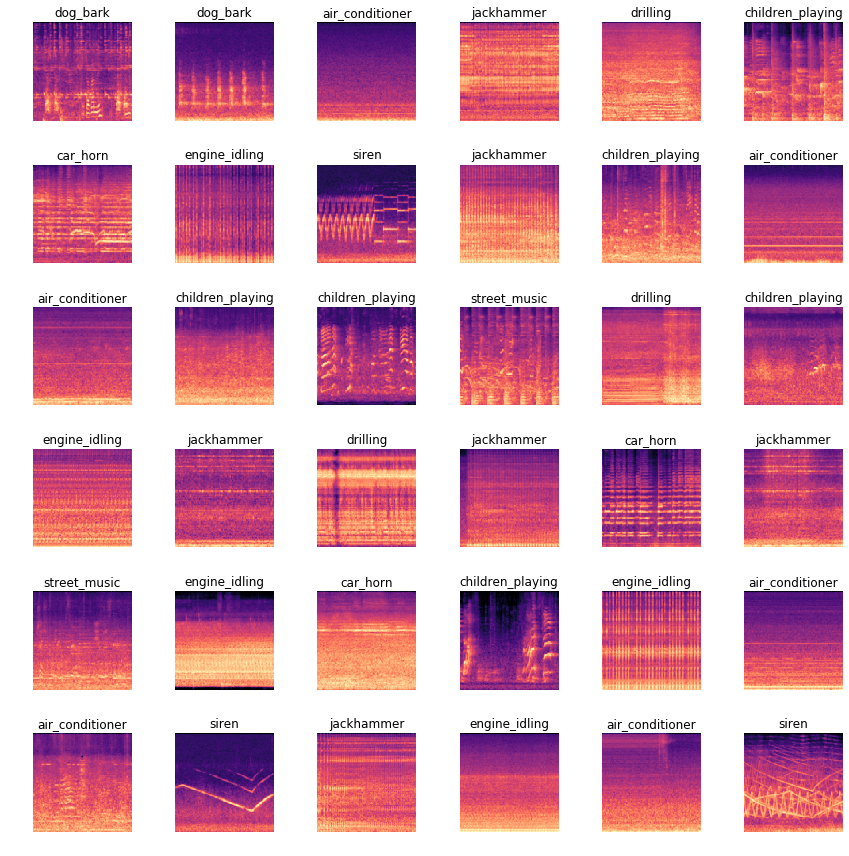

In [26]:
data.show_batch(rows=6, figsize=(12,12))

In [0]:
def process_fold(fold):
    data_directory = Path(base_dir + 'UrbanSound8K/data')
    data = ImageDataBunch.from_folder(data_directory/fold, ds_tfms=[], size=224)
    data.normalize(imagenet_stats)
    learn = cnn_learner(data, models.resnet34, metrics=error_rate)
    learn.fit_one_cycle(3)
    learn.unfreeze()
    learn.fit_one_cycle(1)
    learn.fit_one_cycle(3, max_lr=slice(1e-6,1e-4))

In [27]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 87306240/87306240 [00:05<00:00, 16192959.40it/s]


In [28]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


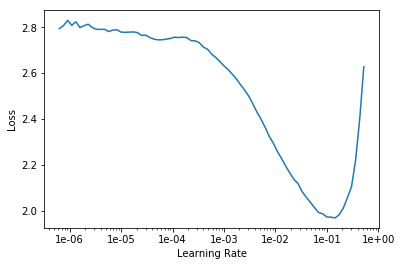

In [29]:
learn.recorder.plot()

In [30]:
learn.fit_one_cycle(4, max_lr=slice(3e-3, 3e-2))

epoch,train_loss,valid_loss,error_rate,time
0,0.821402,0.848426,0.218638,01:05
1,0.559633,0.247310,0.090800,01:05
2,0.310586,0.125149,0.044205,01:05
3,0.162963,0.059726,0.015532,01:05


In [0]:
interp = ClassificationInterpretation.from_learner(learn)

In [32]:
model_path = learn.save('stage-1_resnet34',return_path=True); model_path

PosixPath('/content/gdrive/My Drive/soa/UrbanSound8K/data/models/stage-1_resnet34.pth')

In [33]:
interp.most_confused(min_val=2)

[('dog_bark', 'street_music', 3), ('street_music', 'children_playing', 3)]